In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import itertools
import csv
import os
import re
from requests import get

import unicodedata
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

random_state = 123

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# import acquire
# from acquire import get_article_text

## Changing the acquire function to take a list of lists.

In [2]:
# def get_url_list():
#     urls = []
#     headers = {'User-Agent': 'Student'}
#     url = 'https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=updated&type=Repositories'
#     response = get(url, headers=headers)
#     soup = BeautifulSoup(response.content, 'html.parser')
#     max_page = 3
#     for i in range(1,max_page):
#         url = 'https://github.com/search?o=desc&p=' + str(i) + '&q=stars%3A%3E1&s=updated&type=Repositories/'

#         response = get(url, headers=headers)
#         soup = BeautifulSoup(response.text)
          
#         repo = soup.findAll('li', class_='repo-list-item d-flex flex-column flex-md-row flex-justify-start py-4 public source')
#         for div in repo:
#             one = []
#             one.append(re.findall(r'.*/.*',div.text)[0])
#             urls.append(one)

#     final_urls = []
#     for url in urls:
#         url = 'https://github.com/'+url[0]
#         final_urls.append(url)
        
#     return final_urls

In [3]:
# url_list = get_url_list()

In [4]:
# url_list

In [5]:
# def get_article_text_with_labels():

#     blobs = list(url_list)
#     good_blobs = []
#     read_me_list = []
#     language_top = []
#     stars = []
#     for blob in blobs:
        
#         blob_string=blob.replace(' ', '')
        
#         url_1 = str(blob_string)
#         url = url_1

#         response = requests.get(url)
        
#         soup = BeautifulSoup(response.text) 
# #         print(soup)
        
#         read_me = soup.find(class_='markdown-body entry-content p-5')

#         if read_me != None:
#             if soup.find('span', class_='lang') != None:
#                 language_rm = soup.find('span', class_='lang').text
#                 language_top.append(str(language_rm))
#             else: 
#                 language_top.append('None')
                
#             if soup.find('a', class_='social-count js-social-count') != None:
#                 stars_count = soup.find('a', class_='social-count js-social-count')
#                 stars_count = stars_count.attrs['aria-label']
#                 stars.append(str(stars_count))
#             else: 
#                 stars.append('0')
                
#             read_me_list.append(read_me.text)
#             good_blobs.append(str(blob))
#             stars.append(stars_count)
            
# #     return pd.DataFrame(list(zip(good_blobs,language_top, read_me_list, stars)))         
#     df = pd.DataFrame(list(zip(good_blobs,language_top, read_me_list, stars))) 
#     df.columns = ['title', 'language', 'original', 'stars']
    
#     art_nums = list(range(df.title.count()))        
#     for art_num in art_nums:
#         df.title[art_num] = df.title[art_num].split('.com/')[1]
# #         df.title[art_num] = df.title[art_num].replace(']', '')
# #         df.title[art_num] = df.title[art_num].replace('\'', '')
    
#     return df

In [6]:
# get_article_text_with_labels()

In [7]:
df = pd.read_csv('github_data.csv', header='infer', index_col=0)
df.head(3)

,title,language,original,stars
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17


## Did something wrong happen?  There are a lot of non English characters.  A manual inspection of this readme confirms this is what's in it.  Later on, we'll run a 'basic clean'.  We'll look at the % of words dropped.  If a document returns with only 50-60% of it's original words, it might contain a lot of items that are not considered English.

## Let's work on the columns for 'word counts'.  This is a loose term as we can visually see that some items that were originally hyphenated, and originally considered a single word, come back as multiple words.  Because of this, some readme files actually return more 'words' that the original text contained.

In [8]:
def original_word_count():
    df[['original_cnt']] = df[['original']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        df.original_cnt[art_num] = len(df['original'][art_num].split())
    df['original_cnt']=df['original_cnt'].astype(int)
    return df

In [9]:
original_word_count()
df.head()

,title,language,original,stars,original_cnt
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2,55
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372
3,dotnet/docs.tr-tr,PowerShell,\n\n\nms.openlocfilehash\nms.sourcegitcommit\n...,8,150
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309


In [10]:
def basic_clean():
    
    df[['article']] = df[['original']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        original = df.article[art_num]
        article = re.sub(r'\s', ' ', original).lower()
        normalized = unicodedata.normalize('NFKD', article)
        just_ascii = normalized.encode('ascii', 'ignore')
        article = just_ascii.decode('utf-8')
        without_special_chars = re.sub(r'[^\w\s]', ' ', article)
        word_list = without_special_chars.split()
        article_final = ' '.join(word_list)
        df.article[art_num] = article_final
    return df

In [11]:
basic_clean().head()

,title,language,original,stars,original_cnt,article
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2,55,college hub web based accommodation service bu...
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...
3,dotnet/docs.tr-tr,PowerShell,\n\n\nms.openlocfilehash\nms.sourcegitcommit\n...,8,150,ms openlocfilehash ms sourcegitcommit ms trans...
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...


In [12]:
def article_word_count():
    df[['article_cnt']] = df[['article']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        df.article_cnt[art_num] = len(df['article'][art_num].split())
    df['article_cnt']=df['article_cnt'].astype(int)
    return df

In [13]:
article_word_count().head()

,title,language,original,stars,original_cnt,article,article_cnt
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2,55,college hub web based accommodation service bu...,50
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...,394
3,dotnet/docs.tr-tr,PowerShell,\n\n\nms.openlocfilehash\nms.sourcegitcommit\n...,8,150,ms openlocfilehash ms sourcegitcommit ms trans...,159
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189


In [14]:
def article_percent():    
    df[['article_per_kept']] = df[['article_cnt']]
    df[['article_per_kept']] = df.article_cnt / df.original_cnt
    df['article_per_kept']=df['article_per_kept'].astype(float)
    return df

In [15]:
article_percent()

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2,55,college hub web based accommodation service bu...,50,0.909091
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40,0.952381
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...,394,1.059140
3,dotnet/docs.tr-tr,PowerShell,\n\n\nms.openlocfilehash\nms.sourcegitcommit\n...,8,150,ms openlocfilehash ms sourcegitcommit ms trans...,159,1.060000
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650
5,bajumar/Azure-Monitor-Logs,None,My Azure Monitor Logs Repo\nThis repo contains...,2,98,my azure monitor logs repo this repo contains ...,96,0.979592
6,gigantum/gigantum-testing,Python,Gigantum Testing\nAutomation of Gigantum testi...,3,218,gigantum testing automation of gigantum testin...,208,0.954128
7,dequelabs/cauldron-react,JavaScript,Cauldron React\nThis project is used internall...,4,297,cauldron react this project is used internally...,298,1.003367
8,c-koi/gmic-qt,C++,G'MIC-Qt: a versatile G'MIC plugin\nPurpose\nG...,44,249,g mic qt a versatile g mic plugin purpose g mi...,315,1.265060
9,GeneZharov/introversion,JavaScript,Introversion.js\nTool for debugging JavaScript...,8,3192,introversion js tool for debugging javascript ...,3075,0.963346


## Let's take a look at files that returned less than 70% of their original counts.  They do appear to have a lot of non-English characters as suspected.

In [16]:
df[df.article_per_kept < .7]

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650
43,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000
49,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000
57,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000
62,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000
98,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650
101,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650
123,dotnet/docs.zh-cn,PowerShell,.NET Docs\n此存储库包含适用于 .NET 的概念文档。 .NET 文档站点建立在多...,265,34,net docs net net api net compiler platform sdk...,14,0.411765
130,dotnet/docs.ja-jp,PowerShell,.NET ドキュメント\nこのリポジトリには、.NET の概念に関するドキュメントが含まれて...,28,40,net net net api net compiler platform sdk 3 ne...,20,0.500000
136,dotnet/docs.ja-jp,PowerShell,.NET ドキュメント\nこのリポジトリには、.NET の概念に関するドキュメントが含まれて...,28,40,net net net api net compiler platform sdk 3 ne...,20,0.500000


In [17]:
def lemmatize():
    
    df[['lemmatized']] = df[['article']]
    art_nums = list(range(df.article.count()))
    wnl = nltk.stem.WordNetLemmatizer()
    for art_num in art_nums:
        lemm_article = df.lemmatized[art_num]
        lemmas = [wnl.lemmatize(word) for word in lemm_article.split()]
        article_lemmatized = ' '.join(lemmas)
        df.lemmatized[art_num] = article_lemmatized
    return df

In [18]:
lemmatize().head()

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2,55,college hub web based accommodation service bu...,50,0.909091,college hub web based accommodation service bu...
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40,0.952381,bounce bounce or bounce 2 the ultimate remaste...
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...,394,1.059140,super preloader document complete document dif...
3,dotnet/docs.tr-tr,PowerShell,\n\n\nms.openlocfilehash\nms.sourcegitcommit\n...,8,150,ms openlocfilehash ms sourcegitcommit ms trans...,159,1.060000,m openlocfilehash m sourcegitcommit m translat...
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650,pushqqlove weather and to remind of the time a...


In [19]:
def lemm_word_count():
    df[['lemm_cnt']] = df[['article']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        df.lemm_cnt[art_num] = len(df['lemmatized'][art_num].split())
        
    df.lemm_cnt = df.lemm_cnt.astype(int)
    return df

In [20]:
lemm_word_count().head()

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2,55,college hub web based accommodation service bu...,50,0.909091,college hub web based accommodation service bu...,50
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40,0.952381,bounce bounce or bounce 2 the ultimate remaste...,40
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...,394,1.059140,super preloader document complete document dif...,394
3,dotnet/docs.tr-tr,PowerShell,\n\n\nms.openlocfilehash\nms.sourcegitcommit\n...,8,150,ms openlocfilehash ms sourcegitcommit ms trans...,159,1.060000,m openlocfilehash m sourcegitcommit m translat...,159
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650,pushqqlove weather and to remind of the time a...,189


## The number of words stays the same for each file after lemmatization.  Some of the words have changed, CSS is now just CS.  

In [21]:
df[df.article_cnt != df.lemm_cnt]

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt


## Let's remove stopwords and create two more columns, one for the count of words after stopwords removed and another than shows the percentage of words still left.

In [22]:
def remove_stopwards(extra_words=None, exclude_words=None):
    df = lemmatize()
    stopwords = nltk.corpus.stopwords.words('english')

    
    if extra_words != None:
        stopwords = stopwords + extra_words
    if exclude_words != None:
        stopwords = [word for word in stopwords if word not in exclude_words]
        
    
    df[['clean']] = df[['lemmatized']]
    df[['word_cnt_after_stop']] = df[['title']]

    art_nums = list(range(df.clean.count()))
    for art_num in art_nums:
        words = df.clean[art_num].split()
        without_stopwords = [word for word in words if word not in stopwords]
        df.word_cnt_after_stop[art_num] = len(without_stopwords)
        without_stopwords_join = ' '.join(without_stopwords)
        df.clean[art_num] = without_stopwords_join
    df[['per_stopwords_kept']] = df[['title']]
    df[['per_stopwords_kept']] = df.word_cnt_after_stop / df.lemm_cnt
    df[['per_stopwords_kept']] = df[['per_stopwords_kept']].astype(float)
    
    df[['per_overall_kept']] = df[['title']]
    df[['per_overall_kept']] = df.word_cnt_after_stop / df.original_cnt
    df[['per_overall_kept']] = df[['per_overall_kept']].astype(float)
    
    df[['word_cnt_after_stop']] = df[['word_cnt_after_stop']].astype(int)
   
    return df

In [23]:
remove_stopwards().head()

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
0,IamTinashe/College-Hub,Vue,College-Hub\n\nWeb-based accommodation service...,2,55,college hub web based accommodation service bu...,50,0.909091,college hub web based accommodation service bu...,50,college hub web based accommodation service bu...,43,0.860000,0.781818
1,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40,0.952381,bounce bounce or bounce 2 the ultimate remaste...,40,bounce bounce bounce 2 ultimate remaster wish ...,26,0.650000,0.619048
2,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...,394,1.059140,super preloader document complete document dif...,394,super preloader document complete document dif...,245,0.621827,0.658602
3,dotnet/docs.tr-tr,PowerShell,\n\n\nms.openlocfilehash\nms.sourcegitcommit\n...,8,150,ms openlocfilehash ms sourcegitcommit ms trans...,159,1.060000,m openlocfilehash m sourcegitcommit m translat...,159,openlocfilehash sourcegitcommit translationtyp...,148,0.930818,0.986667
4,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650,pushqqlove weather and to remind of the time a...,189,pushqqlove weather remind time others dev npm ...,175,0.925926,0.566343


In [24]:
df.describe()

,stars,original_cnt,article_cnt,article_per_kept,lemm_cnt,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,600.509677,450.206452,474.270968,1.106672,474.270968,329.154839,0.730738,0.823487
std,1793.949294,633.013302,657.000794,0.439207,657.000794,459.041126,0.127427,0.487797
min,2.000000,1.000000,3.000000,0.411765,3.000000,3.000000,0.468504,0.411765
25%,3.000000,98.000000,101.000000,1.000000,101.000000,62.500000,0.646688,0.653226
50%,12.000000,233.000000,230.000000,1.050459,230.000000,175.000000,0.706897,0.715596
75%,84.000000,415.000000,454.000000,1.083089,454.000000,318.000000,0.785991,0.828888
max,8910.000000,3192.000000,3417.000000,3.600000,3417.000000,2856.000000,1.000000,3.600000


In [25]:
df[df.per_stopwords_kept < .6]

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
5,bajumar/Azure-Monitor-Logs,None,My Azure Monitor Logs Repo\nThis repo contains...,2,98,my azure monitor logs repo this repo contains ...,96,0.979592,my azure monitor log repo this repo contains e...,96,azure monitor log repo repo contains everythin...,50,0.520833,0.510204
11,damng/hackernews-rss-with-inlined-content,Python,hackernews-rss-inlined-content\nLoads the hack...,10,176,hackernews rss inlined content loads the hacke...,202,1.147727,hackernews r inlined content load the hackerne...,202,hackernews r inlined content load hackerness r...,120,0.594059,0.681818
24,artsy/palette,TypeScript,@artsy/palette \nArtsy's Design System\nMeta...,62,277,artsy palette artsy s design system meta point...,294,1.061372,artsy palette artsy s design system meta point...,294,artsy palette artsy design system meta point p...,175,0.595238,0.631769
31,artsy/palette,TypeScript,@artsy/palette \nArtsy's Design System\nMeta...,62,277,artsy palette artsy s design system meta point...,294,1.061372,artsy palette artsy s design system meta point...,294,artsy palette artsy design system meta point p...,175,0.595238,0.631769
67,microsoft/clrmd,C#,Microsoft.Diagnostics.Runtime\n\nMicrosoft.Dia...,515,176,microsoft diagnostics runtime microsoft diagno...,176,1.000000,microsoft diagnostics runtime microsoft diagno...,176,microsoft diagnostics runtime microsoft diagno...,99,0.562500,0.562500
70,nss-day-cohort-30/bangazon-api-whimsical-whoop...,C#,"Building the Bangazon Platform API\nWelcome, n...",3,382,building the bangazon platform api welcome new...,384,1.005236,building the bangazon platform api welcome new...,384,building bangazon platform api welcome new ban...,216,0.562500,0.565445
99,bajumar/Azure-Monitor-Logs,None,My Azure Monitor Logs Repo\nThis repo contains...,2,98,my azure monitor logs repo this repo contains ...,96,0.979592,my azure monitor log repo this repo contains e...,96,azure monitor log repo repo contains everythin...,50,0.520833,0.510204
102,bajumar/Azure-Monitor-Logs,None,My Azure Monitor Logs Repo\nThis repo contains...,2,98,my azure monitor logs repo this repo contains ...,96,0.979592,my azure monitor log repo this repo contains e...,96,azure monitor log repo repo contains everythin...,50,0.520833,0.510204
108,dOrgTech/DAOcreator,TypeScript,DAOcreator\nWizard for setting up your own DAO...,7,41,daocreator wizard for setting up your own daos...,43,1.048780,daocreator wizard for setting up your own daos...,43,daocreator wizard setting daostack dao interes...,23,0.534884,0.560976
113,dOrgTech/DAOcreator,TypeScript,DAOcreator\nWizard for setting up your own DAO...,7,41,daocreator wizard for setting up your own daos...,43,1.048780,daocreator wizard for setting up your own daos...,43,daocreator wizard setting daostack dao interes...,23,0.534884,0.560976


In [26]:
df[df.original_cnt < 11]

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
68,REDasmOrg/REDasm-Library,C++,LibREDasm\nREDasm Core Library\n,20,4,libredasm redasm core library,4,1.0,libredasm redasm core library,4,libredasm redasm core library,4,1.0,1.0
71,nao-romasaga/nao-romasaga.github.io,HTML,nao-romasaga.github.io\ntest\n,2,2,nao romasaga github io test,5,2.5,nao romasaga github io test,5,nao romasaga github io test,5,1.0,2.5
119,iterami/Guides.htm,HTML,iterami/Guides.htm\n\nContributing: https://gi...,2,5,iterami guides htm contributing https github c...,18,3.6,iterami guide htm contributing http github com...,18,iterami guide htm contributing http github com...,18,1.0,3.6
122,iterami/Guides.htm,HTML,iterami/Guides.htm\n\nContributing: https://gi...,2,5,iterami guides htm contributing https github c...,18,3.6,iterami guide htm contributing http github com...,18,iterami guide htm contributing http github com...,18,1.0,3.6
132,ESW1234/esw1234.github.io,HTML,esw1234.github.io\n,2,1,esw1234 github io,3,3.0,esw1234 github io,3,esw1234 github io,3,1.0,3.0
138,ESW1234/esw1234.github.io,HTML,esw1234.github.io\n,2,1,esw1234 github io,3,3.0,esw1234 github io,3,esw1234 github io,3,1.0,3.0
145,ESW1234/esw1234.github.io,HTML,esw1234.github.io\n,2,1,esw1234 github io,3,3.0,esw1234 github io,3,esw1234 github io,3,1.0,3.0


## We will drop files that contain less than 10 words when originally pulled.

In [27]:
df = df[df.original_cnt > 10]

## This will allow us to focus on languages that occur in our set over 5 times.

In [28]:
language_df = pd.DataFrame(df.language.value_counts()[df.language.value_counts() > 5])
language_df

,language
JavaScript,24
Python,23
TypeScript,14
PowerShell,13
None,8
Java,8
C#,6
C++,6


In [29]:
language_df.reset_index(inplace=True)
language_df

,index,language
0,JavaScript,24
1,Python,23
2,TypeScript,14
3,PowerShell,13
4,None,8
5,Java,8
6,C#,6
7,C++,6


In [30]:
language_df.columns = ['language', 'count']
language_df

,language,count
0,JavaScript,24
1,Python,23
2,TypeScript,14
3,PowerShell,13
4,None,8
5,Java,8
6,C#,6
7,C++,6


In [31]:
df = pd.merge(df, language_df, on='language', how='inner')
df

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,count
0,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40,0.952381,bounce bounce or bounce 2 the ultimate remaste...,40,bounce bounce bounce 2 ultimate remaster wish ...,26,0.650000,0.619048,24
1,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...,394,1.059140,super preloader document complete document dif...,394,super preloader document complete document dif...,245,0.621827,0.658602,24
2,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650,pushqqlove weather and to remind of the time a...,189,pushqqlove weather remind time others dev npm ...,175,0.925926,0.566343,24
3,dequelabs/cauldron-react,JavaScript,Cauldron React\nThis project is used internall...,4,297,cauldron react this project is used internally...,298,1.003367,cauldron react this project is used internally...,298,cauldron react project used internally deque s...,192,0.644295,0.646465,24
4,GeneZharov/introversion,JavaScript,Introversion.js\nTool for debugging JavaScript...,8,3192,introversion js tool for debugging javascript ...,3075,0.963346,introversion j tool for debugging javascript e...,3075,introversion j tool debugging javascript expre...,2100,0.682927,0.657895,24
5,sphereio/sphere-node-cli,JavaScript,\nNode.js CLI\n\n\n\n\n\nThe next generation C...,3,570,node js cli the next generation command line i...,628,1.101754,node j cli the next generation command line in...,628,node j cli next generation command line interf...,471,0.750000,0.826316,24
6,ApptivaAG/apptiva-webpage,JavaScript,Apptiva Webpage\nThis repo contains the websit...,2,120,apptiva webpage this repo contains the website...,128,1.066667,apptiva webpage this repo contains the website...,128,apptiva webpage repo contains website apptiva ...,99,0.773438,0.825000,24
7,tlambert03/FPbase,JavaScript,\nFPbase: The Fluorescent Protein Database\n\n...,11,227,fpbase the fluorescent protein database https ...,244,1.074890,fpbase the fluorescent protein database http w...,244,fpbase fluorescent protein database http www f...,177,0.725410,0.779736,24
8,tlambert03/FPbase,JavaScript,\nFPbase: The Fluorescent Protein Database\n\n...,11,227,fpbase the fluorescent protein database https ...,244,1.074890,fpbase the fluorescent protein database http w...,244,fpbase fluorescent protein database http www f...,177,0.725410,0.779736,24
9,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40,0.952381,bounce bounce or bounce 2 the ultimate remaste...,40,bounce bounce bounce 2 ultimate remaster wish ...,26,0.650000,0.619048,24


In [32]:
df.drop(columns='count', inplace=True)
df.head(3)

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
0,EetuPe/Bounce,JavaScript,Bounce\nBounce (or bounce 2 : the ultimate rem...,3,42,bounce bounce or bounce 2 the ultimate remaste...,40,0.952381,bounce bounce or bounce 2 the ultimate remaste...,40,bounce bounce bounce 2 ultimate remaster wish ...,26,0.650000,0.619048
1,machsix/Super-preloader,JavaScript,\n \nSuper-preloader\nDocument\nComplete D...,17,372,super preloader document complete document dif...,394,1.059140,super preloader document complete document dif...,394,super preloader document complete document dif...,245,0.621827,0.658602
2,vadxq/pushQQlove,JavaScript,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650,pushqqlove weather and to remind of the time a...,189,pushqqlove weather remind time others dev npm ...,175,0.925926,0.566343


In [33]:
df.describe()

,stars,original_cnt,article_cnt,article_per_kept,lemm_cnt,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,814.421569,460.274510,476.137255,1.006180,476.137255,330.450980,0.723752,0.717825
std,2170.716373,662.645495,665.592821,0.179406,665.592821,447.524603,0.128571,0.151716
min,2.000000,17.000000,14.000000,0.411765,14.000000,11.000000,0.468504,0.411765
25%,4.000000,124.000000,130.000000,0.989394,130.000000,96.000000,0.644295,0.631769
50%,11.000000,251.500000,244.000000,1.043384,244.000000,176.000000,0.710401,0.698052
75%,56.000000,382.000000,413.000000,1.073113,413.000000,307.000000,0.750000,0.803665
max,8910.000000,3192.000000,3075.000000,1.283489,3075.000000,2100.000000,1.000000,1.048193


In [34]:
df[df.article_per_kept < .6]

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
28,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000,net doc net net api net compiler platform sdk ...,22,net doc net net api net compiler platform sdk ...,21,0.954545,0.477273
30,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000,net doc net net api net compiler platform sdk ...,22,net doc net net api net compiler platform sdk ...,21,0.954545,0.477273
31,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000,net doc net net api net compiler platform sdk ...,22,net doc net net api net compiler platform sdk ...,21,0.954545,0.477273
32,dotnet/docs.zh-tw,PowerShell,.NET Docs\n此存放庫包含 .NET 的概念文件。 .NET 文件網站使用了多個存放...,21,44,net docs net net api net compiler platform sdk...,22,0.500000,net doc net net api net compiler platform sdk ...,22,net doc net net api net compiler platform sdk ...,21,0.954545,0.477273
34,dotnet/docs.zh-cn,PowerShell,.NET Docs\n此存储库包含适用于 .NET 的概念文档。 .NET 文档站点建立在多...,265,34,net docs net net api net compiler platform sdk...,14,0.411765,net doc net net api net compiler platform sdk ...,14,net doc net net api net compiler platform sdk ...,14,1.000000,0.411765
35,dotnet/docs.ja-jp,PowerShell,.NET ドキュメント\nこのリポジトリには、.NET の概念に関するドキュメントが含まれて...,28,40,net net net api net compiler platform sdk 3 ne...,20,0.500000,net net net api net compiler platform sdk 3 ne...,20,net net net api net compiler platform sdk 3 ne...,19,0.950000,0.475000
36,dotnet/docs.ja-jp,PowerShell,.NET ドキュメント\nこのリポジトリには、.NET の概念に関するドキュメントが含まれて...,28,40,net net net api net compiler platform sdk 3 ne...,20,0.500000,net net net api net compiler platform sdk 3 ne...,20,net net net api net compiler platform sdk 3 ne...,19,0.950000,0.475000


## Visualizations

AxesSubplot(0.125,0.125;0.775x0.755)


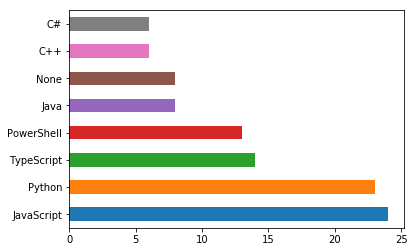

In [35]:
print(df.language.value_counts().plot.barh())

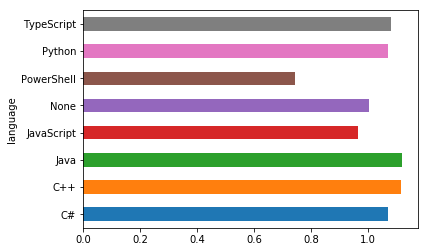

In [36]:
df.groupby('language')['article_per_kept'].mean().plot.barh()

In [37]:
def df_info():
    cols = ['stars',
 'original_cnt',
 'article_cnt',
 'article_per_kept',
 'lemm_cnt',
 'word_cnt_after_stop',
 'per_stopwords_kept',
 'per_overall_kept']
    
    for col in cols:
        print(str(col) + ':')
        print(pd.DataFrame(df.groupby('language')[col].describe().T))

In [38]:
df_info()

stars:
language           C#         C++         Java  JavaScript        None  \
count        6.000000    6.000000     8.000000   24.000000    8.000000   
mean      2020.166667   79.166667  4070.625000    6.791667  144.750000   
std       3246.682579  111.248221  3748.605605    4.969290  264.321638   
min          3.000000    2.000000    11.000000    2.000000    2.000000   
25%        149.000000   12.500000    11.000000    3.000000    2.000000   
50%       1027.500000   44.000000  4904.000000    5.000000    2.000000   
75%       1540.000000   75.500000  5905.500000   10.000000  144.750000   
max       8496.000000  297.000000  8910.000000   17.000000  573.000000   

language  PowerShell      Python   TypeScript  
count      13.000000   23.000000    14.000000  
mean       33.923077   87.000000  2439.071429  
std        70.014834  196.223666  3400.369018  
min         5.000000    3.000000     7.000000  
25%         5.000000    3.500000    12.000000  
50%        21.000000   10.000000    40

In [303]:
def groupby_language_mean_plots():
    cols = ['stars',
 'original_cnt',
 'article_cnt',
 'article_per_kept',
 'lemm_cnt',
 'word_cnt_after_stop',
 'per_stopwords_kept',
 'per_overall_kept']
    
    for col in cols:
        print(str(col) + ':')
        plot = df.groupby('language')[col].mean().plot.barh()
        print(plt.show())

stars:


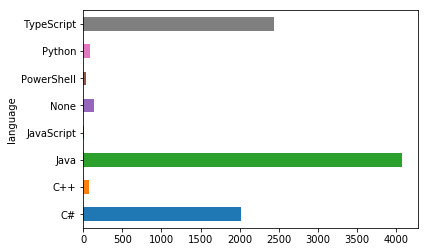

None
original_cnt:


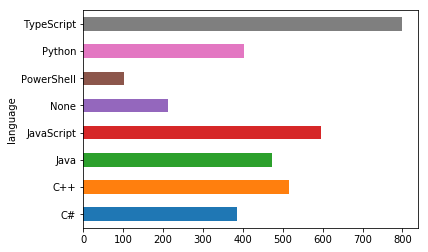

None
article_cnt:


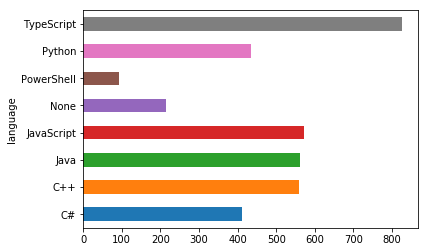

None
article_per_kept:


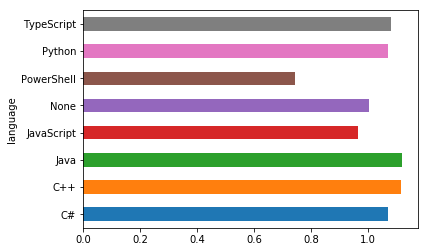

None
lemm_cnt:


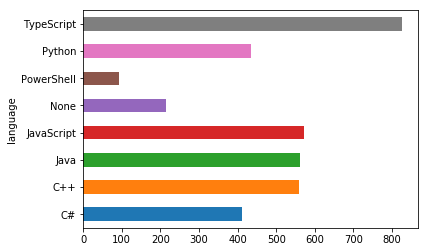

None
word_cnt_after_stop:


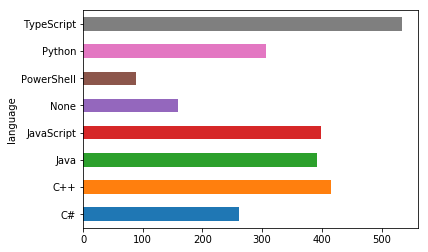

None
per_stopwords_kept:


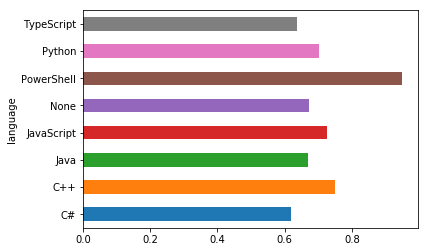

None
per_overall_kept:


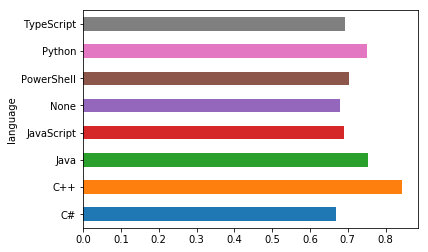

None


In [304]:
groupby_language_mean_plots()

## Let's explore the readme's that are Python

In [290]:
py = df[df.language == 'Python']
py.head(3)

,title,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,lang_encoded
45,gigantum/gigantum-testing,Python,Gigantum Testing\nAutomation of Gigantum testi...,3,218,gigantum testing automation of gigantum testin...,208,0.954128,gigantum testing automation of gigantum testin...,208,gigantum testing automation gigantum testing s...,156,0.750000,0.715596,6
46,damng/hackernews-rss-with-inlined-content,Python,hackernews-rss-inlined-content\nLoads the hack...,10,176,hackernews rss inlined content loads the hacke...,202,1.147727,hackernews r inlined content load the hackerne...,202,hackernews r inlined content load hackerness r...,120,0.594059,0.681818,6
47,bazelbuild/rules_jvm_external,Python,rules_jvm_external\nTransitive Maven artifact ...,46,1077,rules_jvm_external transitive maven artifact r...,1150,1.067781,rules_jvm_external transitive maven artifact r...,1150,rules_jvm_external transitive maven artifact r...,839,0.729565,0.779016,6


In [177]:
py_words = ' '.join(py.article)

(-0.5, 399.5, 199.5, -0.5)

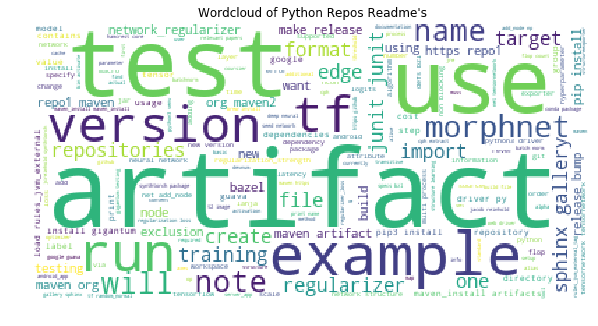

In [178]:
from wordcloud import WordCloud
img = WordCloud(background_color='white').generate(py_words)

plt.figure(figsize=(10,10))
plt.imshow(img)

plt.title('Wordcloud of Python Repos Readme\'s')
plt.axis('off')

## Modeling

In [207]:
docs = dict(zip(df.language.values, df.clean.values))

In [208]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [209]:
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(docs.values())
tfidfs

<8x926 sparse matrix of type '<class 'numpy.float64'>'
	with 1134 stored elements in Compressed Sparse Row format>

In [210]:
sm = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
sm

,015,05046,0741927,07s,0847295,10,100,1047696,1137,1145,...,wrote,www,xamarinmono,xml,yanai,yokoi,youtube,yukina,yvonne,zip
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.13612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.061821,0.000000,0.00000,0.000000,0.000000,0.000000,0.061821,0.000000,0.000000,0.000000
3,0.023215,0.000000,0.000000,0.023215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023215
4,0.000000,0.018801,0.018801,0.000000,0.018801,0.094006,0.037602,0.018801,0.018801,0.018801,...,0.000000,0.000000,0.00000,0.000000,0.018801,0.018801,0.000000,0.018801,0.018801,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.082632,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.039004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [211]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

bow_X = tfidf.fit_transform(df.clean)
bow_y = df.language

bow_X_train, bow_X_test, bow_y_train, bow_y_test = train_test_split(bow_X, bow_y, stratify=bow_y, test_size=.2, random_state=random_state)
# not sure if we need to stratify y... so not doing it here... I think this is unneccessary because we dont have unbalanced set.
bow_train = pd.DataFrame(dict(actual=bow_y_train))
bow_test = pd.DataFrame(dict(actual=bow_y_test))


bow_lm = LogisticRegression().fit(bow_X_train, bow_y_train)

bow_train['predicted'] = bow_lm.predict(bow_X_train)
bow_test['predicted'] = bow_lm.predict(bow_X_test)

In [212]:
print('Accuracy: {:.2%}'.format(accuracy_score(bow_train.actual, bow_train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(bow_train.predicted, bow_train.actual))
print('---')
print(classification_report(bow_train.actual, bow_train.predicted))

Accuracy: 90.12%
---
Confusion Matrix
actual      C#  C++  Java  JavaScript  None  PowerShell  Python  TypeScript
predicted                                                                  
C#           2    0     0           0     0           0       0           0
C++          0    2     0           0     0           0       0           0
Java         0    0     6           0     0           0       0           0
JavaScript   2    3     0          19     0           0       0           0
None         0    0     0           0     5           0       0           0
PowerShell   0    0     0           0     0          10       0           0
Python       1    0     1           0     1           0      18           0
TypeScript   0    0     0           0     0           0       0          11
---
              precision    recall  f1-score   support

          C#       1.00      0.40      0.57         5
         C++       1.00      0.40      0.57         5
        Java       1.00      0.86  

In [213]:
print('Accuracy: {:.2%}'.format(accuracy_score(bow_test.actual, bow_test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(bow_test.predicted, bow_test.actual))
print('---')
print(classification_report(bow_test.actual, bow_test.predicted))

Accuracy: 80.95%
---
Confusion Matrix
actual      C#  C++  Java  JavaScript  None  PowerShell  Python  TypeScript
predicted                                                                  
JavaScript   1    1     0           5     0           0       0           0
None         0    0     0           0     1           0       0           0
PowerShell   0    0     0           0     0           3       0           0
Python       0    0     1           0     1           0       5           0
TypeScript   0    0     0           0     0           0       0           3
---
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         1
         C++       0.00      0.00      0.00         1
        Java       0.00      0.00      0.00         1
  JavaScript       0.71      1.00      0.83         5
        None       1.00      0.50      0.67         2
  PowerShell       1.00      1.00      1.00         3
      Python       0.71      1.00      0.83    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Let's check to see what we got wrong and confirm that predictions merged correctly.

In [214]:
bow_train[bow_train.actual != bow_train.predicted]

,actual,predicted
77,C#,JavaScript
44,None,Python
73,C++,JavaScript
75,C#,JavaScript
74,C#,Python
72,C++,JavaScript
94,Java,Python
68,C++,JavaScript


In [215]:
df.iloc[44].language

'None'

## Let's take the predictions from our Logistic Regression and merge those into train and test sets.  The predictions from LR will be used as a feature in a different model.  As of now, we have only really used the bag of words as the feature.  We'd like to use length of readme, etc. as features.

## Let's encode our y-value to use in a decision tree.

In [216]:
from sklearn.preprocessing import LabelEncoder

In [217]:
lang_groups = pd.DataFrame(df.language.unique())
lang_groups.columns = ['language']
lang_groups

,language
0,JavaScript
1,PowerShell
2,None
3,Python
4,C++
5,C#
6,TypeScript
7,Java


In [218]:
encoder = LabelEncoder()
encoder.fit(lang_groups.language)
lang_groups[['lang_encoded']] = lang_groups[['language']]
lang_groups.lang_encoded = encoder.transform(lang_groups.lang_encoded)
lang_groups

,language,lang_encoded
0,JavaScript,3
1,PowerShell,5
2,None,4
3,Python,6
4,C++,1
5,C#,0
6,TypeScript,7
7,Java,2


In [219]:
# df = pd.merge(df, lang_groups, how='inner', on='language')
# df.head(3)

In [233]:
bow_train_preds = pd.DataFrame(bow_train.predicted)
bow_train_preds.head()

,predicted
5,JavaScript
89,TypeScript
45,Python
48,Python
77,JavaScript


In [234]:
bow_test_preds = pd.DataFrame(bow_test.predicted)
bow_test_preds.head()

,predicted
76,JavaScript
14,JavaScript
95,Python
4,JavaScript
19,JavaScript


In [235]:
X_train = pd.merge(bow_train, df, left_index=True, right_index=True)
X_train.drop(columns=['actual', 'language'], inplace=True)
X_train.rename(columns={'lang_encoded':'pred_lang_encoded'}, inplace=True)
X_train.head(3)

,predicted,title,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,pred_lang_encoded
5,JavaScript,sphereio/sphere-node-cli,\nNode.js CLI\n\n\n\n\n\nThe next generation C...,3,570,node js cli the next generation command line i...,628,1.101754,node j cli the next generation command line in...,628,node j cli next generation command line interf...,471,0.750000,0.826316,3
89,TypeScript,pnpm/pnpm,"\npnpm\n\nFast, disk space efficient package m...",5805,435,pnpm fast disk space efficient package manager...,454,1.043678,pnpm fast disk space efficient package manager...,454,pnpm fast disk space efficient package manager...,285,0.627753,0.655172,7
45,Python,gigantum/gigantum-testing,Gigantum Testing\nAutomation of Gigantum testi...,3,218,gigantum testing automation of gigantum testin...,208,0.954128,gigantum testing automation of gigantum testin...,208,gigantum testing automation gigantum testing s...,156,0.750000,0.715596,6


In [236]:
X_test = pd.merge(bow_test, df, left_index=True, right_index=True)
X_test.drop(columns=['actual', 'language'], inplace=True)
X_test.rename(columns={'lang_encoded':'pred_lang_encoded'}, inplace=True)
X_test.head(3)

,predicted,title,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,pred_lang_encoded
76,JavaScript,nss-day-cohort-30/bangazon-api-whimsical-whoop...,"Building the Bangazon Platform API\nWelcome, n...",3,382,building the bangazon platform api welcome new...,384,1.005236,building the bangazon platform api welcome new...,384,building bangazon platform api welcome new ban...,216,0.562500,0.565445,0
14,JavaScript,vadxq/pushQQlove,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650,pushqqlove weather and to remind of the time a...,189,pushqqlove weather remind time others dev npm ...,175,0.925926,0.566343,3
95,Python,oracle/graal,GraalVM\n\nGraalVM is a universal virtual mach...,8910,343,graalvm graalvm is a universal virtual machine...,355,1.034985,graalvm graalvm is a universal virtual machine...,355,graalvm graalvm universal virtual machine runn...,245,0.690141,0.714286,2


In [237]:
y_train = pd.DataFrame(bow_train.actual)
y_train = pd.merge(y_train, pd.DataFrame(df.language), right_index=True, left_index=True)
y_train.head(3)

,actual,language
5,JavaScript,JavaScript
89,TypeScript,TypeScript
45,Python,Python


In [238]:
y_train = pd.merge(y_train, lang_groups, how='left', on='language')
y_train.head(3)

,actual,language,lang_encoded
0,JavaScript,JavaScript,3
1,TypeScript,TypeScript,7
2,Python,Python,6


In [239]:
y_test = pd.DataFrame(bow_test.actual)
y_test = pd.merge(y_test, pd.DataFrame(df.language), right_index=True, left_index=True)
y_test.head(3)

,actual,language
76,C#,C#
14,JavaScript,JavaScript
95,Java,Java


In [240]:
y_test = pd.merge(y_test, lang_groups, how='left', on='language')
y_test.head(3)

,actual,language,lang_encoded
0,C#,C#,0
1,JavaScript,JavaScript,3
2,Java,Java,2


In [241]:
y_train.drop(columns=['actual', 'language'], inplace=True)
y_test.drop(columns=['actual', 'language'], inplace=True)

In [242]:
X_train[['pred_lang_encoded']] = X_train[['predicted']]
X_train[['language']] = X_train[['predicted']]
X_train = pd.merge(X_train, lang_groups, how='left', on='language')
X_train.drop(columns=['language', 'pred_lang_encoded'], inplace=True)
X_train.rename(index=str, columns={'lang_encoded': 'pred_lang_encoded'}, inplace=True)
X_train.head(3)

,predicted,title,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,pred_lang_encoded
0,JavaScript,sphereio/sphere-node-cli,\nNode.js CLI\n\n\n\n\n\nThe next generation C...,3,570,node js cli the next generation command line i...,628,1.101754,node j cli the next generation command line in...,628,node j cli next generation command line interf...,471,0.750000,0.826316,3
1,TypeScript,pnpm/pnpm,"\npnpm\n\nFast, disk space efficient package m...",5805,435,pnpm fast disk space efficient package manager...,454,1.043678,pnpm fast disk space efficient package manager...,454,pnpm fast disk space efficient package manager...,285,0.627753,0.655172,7
2,Python,gigantum/gigantum-testing,Gigantum Testing\nAutomation of Gigantum testi...,3,218,gigantum testing automation of gigantum testin...,208,0.954128,gigantum testing automation of gigantum testin...,208,gigantum testing automation gigantum testing s...,156,0.750000,0.715596,6


In [243]:
X_test[['pred_lang_encoded']] = X_test[['predicted']]
X_test[['language']] = X_test[['predicted']]
X_test = pd.merge(X_test, lang_groups, how='left', on='language')
X_test.drop(columns=['language', 'pred_lang_encoded'], inplace=True)
X_test.rename(index=str, columns={'lang_encoded': 'pred_lang_encoded'}, inplace=True)
X_test.head(3)

,predicted,title,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,pred_lang_encoded
0,JavaScript,nss-day-cohort-30/bangazon-api-whimsical-whoop...,"Building the Bangazon Platform API\nWelcome, n...",3,382,building the bangazon platform api welcome new...,384,1.005236,building the bangazon platform api welcome new...,384,building bangazon platform api welcome new ban...,216,0.562500,0.565445,3
1,JavaScript,vadxq/pushQQlove,pushQQlove\nweather and to remind of the time ...,2,309,pushqqlove weather and to remind of the time a...,189,0.611650,pushqqlove weather and to remind of the time a...,189,pushqqlove weather remind time others dev npm ...,175,0.925926,0.566343,3
2,Python,oracle/graal,GraalVM\n\nGraalVM is a universal virtual mach...,8910,343,graalvm graalvm is a universal virtual machine...,355,1.034985,graalvm graalvm is a universal virtual machine...,355,graalvm graalvm universal virtual machine runn...,245,0.690141,0.714286,6


In [244]:
clf_X_train = X_train[['original_cnt', 'article_per_kept', 'per_overall_kept', 'pred_lang_encoded']]
clf_X_test = X_test[['original_cnt', 'article_per_kept', 'per_overall_kept', 'pred_lang_encoded']]

### To confirm that we're not using the actual languages, we ran a model with just the pred_lang_encoded from the bag of words.  The results were the exaxt same.

In [246]:
# clf_X_train = X_train[['pred_lang_encoded']]
# clf_X_test = X_test[['pred_lang_encoded']]

In [260]:
clf_X_train = X_train[['stars', 'original_cnt', 'article_per_kept', 'per_overall_kept', 'per_stopwords_kept', 'pred_lang_encoded']]
clf_X_test = X_test[['stars', 'original_cnt', 'article_per_kept', 'per_overall_kept', 'per_stopwords_kept', 'pred_lang_encoded']]

In [261]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

In [262]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=random_state)

In [263]:
clf.fit(clf_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [266]:
train_clf_y_pred = clf.predict(clf_X_train)
train_clf_y_pred[:5]

array([3, 7, 6, 6, 1])

In [267]:
train_clf_y_pred_proba = clf.predict_proba(clf_X_train)
train_clf_y_pred_proba[:5]

array([[0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
       [0.4, 0.6, 0. , 0. , 0. , 0. , 0. , 0. ]])

In [268]:
print('Accuracy of Decision Tree classifier on training set: {:.4f}'
     .format(clf.score(clf_X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.9753


In [269]:
from sklearn.metrics import confusion_matrix

In [278]:
print('Train Confusion Matrix')
labels = sorted(df.language.unique())
pd.DataFrame(confusion_matrix(y_train, train_clf_y_pred), index=labels, columns=labels)

Train Confusion Matrix


,C#,C++,Java,JavaScript,None,PowerShell,Python,TypeScript
C#,3,2,0,0,0,0,0,0
C++,0,5,0,0,0,0,0,0
Java,0,0,7,0,0,0,0,0
JavaScript,0,0,0,19,0,0,0,0
None,0,0,0,0,6,0,0,0
PowerShell,0,0,0,0,0,10,0,0
Python,0,0,0,0,0,0,18,0
TypeScript,0,0,0,0,0,0,0,11


In [271]:
print(classification_report(y_train, train_clf_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        11

   micro avg       0.98      0.98      0.98        81
   macro avg       0.96      0.95      0.95        81
weighted avg       0.98      0.98      0.97        81



## This seems to be extremely great.  Let's try it on the test.

In [272]:
test_clf_y_pred = clf.predict(clf_X_test)
test_clf_y_pred[:5]

array([3, 3, 2, 3, 3])

In [273]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'
     .format(clf.score(clf_X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9524


In [279]:
print('Test Confusion Matrix')
labels = sorted(df.language.unique())
pd.DataFrame(confusion_matrix(y_test, test_clf_y_pred), index=labels, columns=labels)

Test Confusion Matrix


,C#,C++,Java,JavaScript,None,PowerShell,Python,TypeScript
C#,0,0,0,1,0,0,0,0
C++,0,1,0,0,0,0,0,0
Java,0,0,1,0,0,0,0,0
JavaScript,0,0,0,5,0,0,0,0
None,0,0,0,0,2,0,0,0
PowerShell,0,0,0,0,0,3,0,0
Python,0,0,0,0,0,0,5,0
TypeScript,0,0,0,0,0,0,0,3


In [275]:
print(classification_report(y_test, test_clf_y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         3

   micro avg       0.95      0.95      0.95        21
   macro avg       0.85      0.88      0.86        21
weighted avg       0.91      0.95      0.93        21



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
import graphviz

from graphviz import Graph

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 

graph.render('readme_decision_tree', view=True)

'readme_decision_tree.pdf'